## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [78]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('./ab_data.csv')
df.head() #use print for the script version

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [4]:
df.describe()

user_id      converted
count  294478.000000  294478.000000
mean   787974.124733       0.119659
std     91210.823776       0.324563
min    630000.000000       0.000000
25%    709032.250000       0.000000
50%    787933.500000       0.000000
75%    866911.750000       0.000000
max    945999.000000       1.000000

b. Use the cell below to find the number of rows in the dataset.

In [5]:
n = df.shape[0]
print('The number of rows/samples in this dataset is {}'.format(n))

The number of rows/samples in this dataset is 294478


c. The number of unique users in the dataset.

In [6]:
n_users = df['user_id'].nunique()
print('The number of unique users is {}'.format(n_users))

The number of unique users is 290584


d. The proportion of users converted.

In [7]:
n_users_conv = df['converted'].sum()
n_users_conv_prop = n_users_conv / n_users
print('The number of converted users is {}'.format(n_users_conv_prop))

The number of converted users is 0.12126269856564711


e. The number of times the `new_page` and `treatment` don't match.

In [8]:
df_op_treat = df.query('(group == "treatment") and (landing_page != "new_page")')
n_op_treat = df_op_treat.shape[0]

In [9]:
df_np_control = df.query('(group == "control") and (landing_page != "old_page")')
df_np_control = df_np_control.shape[0]

In [10]:
n_no_match = n_op_treat + df_np_control
n_no_match

3893

f. Do any of the rows have missing values?

In [11]:
n_nans = df.isnull().sum()
labels = n_nans.index
for i in labels:
    print('The number of missing values is in {} is {}'.format(i,n_nans[i]))

The number of missing values is in user_id is 0
The number of missing values is in timestamp is 0
The number of missing values is in group is 0
The number of missing values is in landing_page is 0
The number of missing values is in converted is 0


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [12]:
df2 = df.copy()

In [13]:
indices_con = df2[(df2['group'] == "control") & (df2['landing_page'] != "old_page")].index

In [14]:
indices_tre = df2[(df2['group'] == 'treatment') & (df2['landing_page'] != 'new_page')].index

In [15]:
indices = indices_con.append(indices_tre)
df2.drop(labels=indices,axis=0,inplace=True)

In [16]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'control') == (df2['landing_page'] == 'old_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [18]:
unique_users_df2 = df['user_id'].nunique()
print('The number of unique user is now {}'.format(unique_users_df2))

The number of unique user is now 290584


b. There is one **user_id** repeated in **df2**.  What is it?

In [19]:
repeat_users = df2[df2['user_id'].duplicated() == True]

In [20]:
repeat_users.user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [21]:
repeat_users

user_id                   timestamp      group landing_page  converted
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [22]:
#This removes the duplicated user id
df2.drop(labels=repeat_users.index,axis=0,inplace=True)

In [23]:
#This verifies that the duplicated row was removed
df2[df2['user_id'].duplicated() == True].shape[0]

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [24]:
p_conv_reg = df2['converted'].mean()
print('The probability of an individual being converted regardless of the page they receive is: \n{}'.format(p_conv_reg))

The probability of an individual being converted regardless of the page they receive is: 
0.11959708724499628


b. Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
p_conv_contr = df2.query('group == "control"')['converted'].mean()
print('The probability of an individual being converted given they were in the control group is: \n{}'.format(p_conv_contr))

The probability of an individual being converted given they were in the control group is: 
0.1203863045004612


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
p_conv_treat = df2.query('group == "treatment"')['converted'].mean()
print('The probability of an individual being converted given they were in the treatment group is: \n{}'.format(p_conv_treat))

The probability of an individual being converted given they were in the treatment group is: 
0.11880806551510564


d. What is the probability that an individual received the new page?

In [27]:
p_new_page = df2.query('landing_page == "new_page"').shape[0] / df2.shape[0]
print('The probability of an individual receiving the new page is: \n{}'.format(p_new_page))

The probability of an individual receiving the new page is: 
0.5000619442226688


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**The results from parts `b` and `c` are nearly identical. Therefore we can't conclude, yet, that the new landing page should be implemented by the new compnay.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} \geq p_{new} $$
$$H_1: p_{old} < p_{new} $$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [28]:
p_new = p_conv_reg
print('The conversion rate for "p_new" under the null is {}'.format(p_new))

The conversion rate for "p_new" under the null is 0.11959708724499628


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [29]:
p_old = p_conv_reg
print('The conversion rate for the "p_old" under the null is {}'.format(p_old))

The conversion rate for the "p_old" under the null is 0.11959708724499628


c. What is $n_{new}$, the number of individuals in the treatment group?

In [30]:
n_new = df2.query('group == "treatment"').shape[0]
print('The number of individuals in the "treatment" group is {}'.format(n_new))

The number of individuals in the "treatment" group is 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [31]:
n_old = df2.query('group == "control"').shape[0]
print('The number of individuals in the "control" group is {}'.format(n_old))

The number of individuals in the "control" group is 145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
new_page_converted = np.random.choice(a=[0,1],size=n_new,p=[1-p_new,p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [33]:
old_page_converted = np.random.choice(a=[0,1],size=n_old,p=[1-p_old,p_old])
old_page_converted

array([0, 1, 0, ..., 0, 1, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [34]:
new_page_converted.mean() - old_page_converted.mean()

0.0017046982807379374

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [35]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(a=[0,1],size=n_new,p=[1-p_new,p_new])
    old_page_converted = np.random.choice(a=[0,1],size=n_old,p=[1-p_old,p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

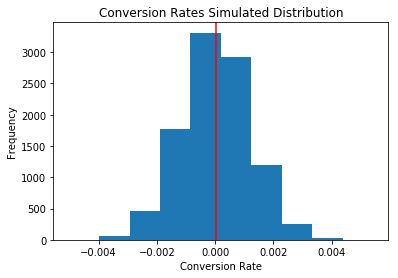

In [36]:
mean_diff=np.array(p_diffs).mean()
plt.hist(p_diffs);
plt.title('Conversion Rates Simulated Distribution');
plt.xlabel('Conversion Rate');
plt.ylabel('Frequency');
plt.axvline(x=mean_diff,color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [37]:
new_page_conv_samp = df2.query('landing_page == "new_page"')['converted'].mean()
old_page_conv_samp = df2.query('landing_page == "old_page"')['converted'].mean()
p_diff_samp = new_page_conv_samp - old_page_conv_samp
print('The difference between the conversion rates found in the sample is {}'.format(p_diff_samp))

The difference between the conversion rates found in the sample is -0.0015782389853555567


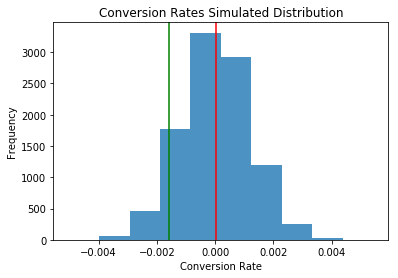

In [38]:
plt.hist(p_diffs,alpha=0.8);
plt.title('Conversion Rates Simulated Distribution');
plt.xlabel('Conversion Rate');
plt.ylabel('Frequency');
plt.axvline(x=mean_diff,color='red');
plt.axvline(x=p_diff_samp,color='green');

In [39]:
perc = (p_diffs > p_diff_samp).mean()
print('The proportion of conversion rates under the null greater than that found in the sample is: \n{}'.format(perc))

The proportion of conversion rates under the null greater than that found in the sample is: 
0.9114


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value just calculated is called the `p-value` associated with observing the conversion rate that we did from our data given the assumptions of the null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [40]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [41]:
z, p = sm.stats.proportions_ztest(count=[convert_old,convert_new],nobs=[n_old,n_new],alternative='smaller')
z,p

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-value tells you where on the standard normal distribution (under the null hypothesis) the lower bound your observed data lies. The p-value is probability that you obtain the data that you did under the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression will be performed since the response is binary.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [50]:
df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  
0          1  
1          1  
2          1  
3          1  
4          1

In [51]:
df2['intercept'] = 1

In [52]:
ab_dummies = pd.get_dummies(df['group'])
ab_dummies.head()

control  treatment
0        1          0
1        1          0
2        0          1
3        0          1
4        1          0

In [53]:
ab_dummies.drop(labels='control',axis=1,inplace=True)
ab_dummies.head()

treatment
0          0
1          0
2          1
3          1
4          0

In [71]:
df3 = df2.copy()

In [72]:
df3 = df3.join(ab_dummies)
labels = ['user_id','timestamp','group','landing_page']
df3.drop(columns=labels,inplace=True)
df3.head()

converted  intercept  treatment
0          0          1          0
1          0          1          0
2          0          1          1
3          0          1          1
4          1          1          0

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [73]:
X = df3.loc[:,['intercept','treatment']]
X.head()

intercept  treatment
0          1          0
1          1          0
2          1          1
3          1          1
4          1          0

In [74]:
y = df3[['converted']]

In [75]:
y.head()

converted
0          0
1          0
2          0
3          0
4          1

In [80]:
log_mod = sm.Logit(y,X)
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [81]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        12:50:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>

**The p-value in the logistic regression model tests the null hypothesis that there is a linear relationship between that variable and the log-odds is linear. In this regression model, the large p-value states we can reject the null hypothesis implying there is no linear relationhip between the new landing page and a user converting.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There is no significance of the control/treatment groups so it would be necessary to add additional features to the model. However, it would not be useful to add a feature such as user_id since that would lead to an artificially large pseudo R-squared. I don't see there being any disadvantages to adding additional features into the model since this model states that the control/treatement groups are not significant.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns.

In [82]:
df_countries = pd.read_csv('./countries.csv')
df_countries.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [130]:
df4 = df2.copy()

In [131]:
ab_dummies = pd.get_dummies(df4[['group']])
ab_dummies.head()

group_control  group_treatment
0              1                0
1              1                0
2              0                1
3              0                1
4              1                0

In [132]:
ab_dummies.drop(labels='group_control',axis=1,inplace=True)
ab_dummies.head()

group_treatment
0                0
1                0
2                1
3                1
4                0

In [133]:
df4 = df4.join(ab_dummies)
df4.drop(labels='group',axis=1,inplace=True)
df4.head()

user_id                   timestamp landing_page  converted  intercept  \
0   851104  2017-01-21 22:11:48.556739     old_page          0          1   
1   804228  2017-01-12 08:01:45.159739     old_page          0          1   
2   661590  2017-01-11 16:55:06.154213     new_page          0          1   
3   853541  2017-01-08 18:28:03.143765     new_page          0          1   
4   864975  2017-01-21 01:52:26.210827     old_page          1          1   

   group_treatment  
0                0  
1                0  
2                1  
3                1  
4                0

In [134]:
df4 = df4.set_index('user_id').join(other=df_countries.set_index('user_id'),how='inner')

In [135]:
labels = ['timestamp','landing_page']
df4.drop(columns=labels,inplace=True)
df4.head()

converted  intercept  group_treatment country
user_id                                               
851104           0          1                0      US
804228           0          1                0      US
661590           0          1                1      US
853541           0          1                1      US
864975           1          1                0      US

In [138]:
unique_countries = df4['country'].nunique()
print('The number of unique countries in this dataset is {}'.format(unique_countries))

The number of unique countries in this dataset is 3


In [141]:
country_dummies = pd.get_dummies(df4['country'],drop_first=True)
country_dummies.head()

UK  US
user_id        
851104    0   1
804228    0   1
661590    0   1
853541    0   1
864975    0   1

In [142]:
df4 = df4.join(country_dummies)
df4.head()

converted  intercept  group_treatment country  UK  US
user_id                                                       
851104           0          1                0      US   0   1
804228           0          1                0      US   0   1
661590           0          1                1      US   0   1
853541           0          1                1      US   0   1
864975           1          1                0      US   0   1

In [143]:
df4.drop(labels='country',axis=1,inplace=True)
df4.head()

converted  intercept  group_treatment  UK  US
user_id                                               
851104           0          1                0   0   1
804228           0          1                0   0   1
661590           0          1                1   0   1
853541           0          1                1   0   1
864975           1          1                0   0   1

In [144]:
X = df4.loc[:,'intercept':'US']
y = df4.loc[:,'converted']
X.head()

intercept  group_treatment  UK  US
user_id                                    
851104           1                0   0   1
804228           1                0   0   1
661590           1                1   0   1
853541           1                1   0   1
864975           1                0   0   1

In [145]:
y.head()

user_id
851104    0
804228    0
661590    0
853541    0
864975    1
Name: converted, dtype: int64

In [147]:
log_mod = sm.Logit(y,X)
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [148]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:01:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept          -2.0300      0.027    -76.249      0.000      -2.082      -1.978
group_treatment    -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK                  0.0506      0.028      1.784      0.074      -0.005       0.106
US                  0.0408      0.027      1.516      0.130      -0.012       0.093
===================================================================================
"""

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [156]:
X['country_interaction'] = X['group_treatment'] * X['US']

In [157]:
X.head()

intercept  group_treatment  UK  US  country_interaction
user_id                                                         
851104           1                0   0   1                    0
804228           1                0   0   1                    0
661590           1                1   0   1                    1
853541           1                1   0   1                    1
864975           1                0   0   1                    0

In [158]:
log_mod = sm.Logit(y,X)
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [159]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Thu, 17 Dec 2020   Pseudo R-squ.:               2.589e-05
Time:                        14:06:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.2390
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept              -2.0366      0.028    -72.618      0.000      -2.092      -1.982
group_treatment        -0.0018      0.021     -0.086      0.931      -0.043       0.039
UK                      0.0507      0.028      1.786      0.074      -0.005       0.106
US                      0.0501      0.030      1.691      0.091      -0.008       0.108
country_interaction    -0.0188      0.025     -0.752      0.452      -0.068       0.030
=======================================================================================
"""

**Adding an interaction between the country and the experimental groups did not produce a linear relationship between the interaction term and the log-odds nor did it increase the pseudo R-squared value. Therefore, at least based on what is calculated in this project, there does NOT seem to be an improvement in conversion rates based on the exeriment performed by the e-commerce company. My recommendation is to not implement the new web page.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!